In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'planck_wgt_flux',
            'option_wgt',
            'fac_meank',
            'klin']


def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation/crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'co2',
                          'band03c_wn_720_800',
                          'ng_9',
                          'g_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__4',
                          'getabsth_auto__auto__semiauto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.6_.4_.7___.7_.5__.3_.4_.85_.95',
                          'bigsum',
                          'option_wgt_1',
                          'chou_0501_-_manual_abscom2_-_151f63b',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [7]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation/crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'co2',
                          'band03c_wn_720_800',
                          'ng_9',
                          'g_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__4',
                          'getabsth_auto__auto__semiauto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.6_.4_.7___.7_.5__.3_.4_.85_.95',
                          'bigsum',
                          'option_wgt_1',
                          'chou_0501_-_manual_abscom2_-_151f63b',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(range(1, 9 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-4, 50)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 720

nband = 80

nv = 200

dv = 0.005

tsfc = 294.0

ng = 9

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   2,   4 /)

data wgt
     &     /.95, .85, .4, .3,
     &     .5, .7,
     &     .7, .4, .6/

planck_wgt_flux = 2

option_wgt = 1

klin = 6.375563e-24

include 'mls75.pro'


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

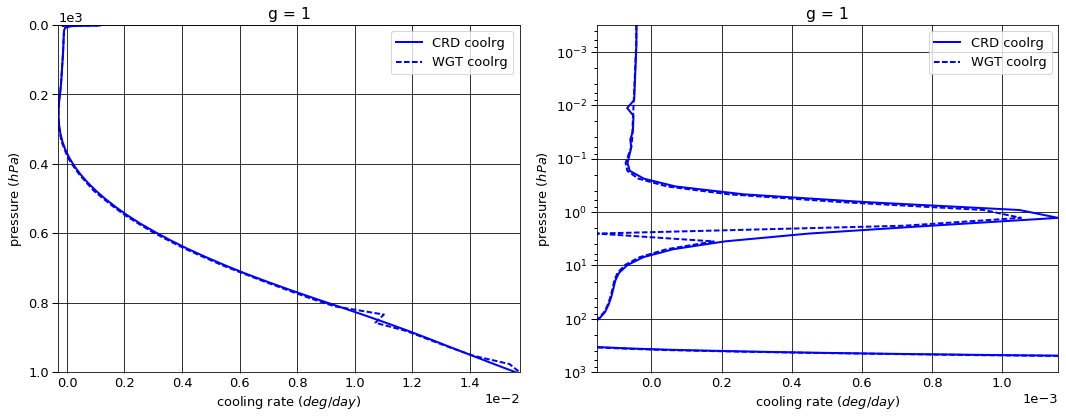

# Figure: cooling rate g-group 2

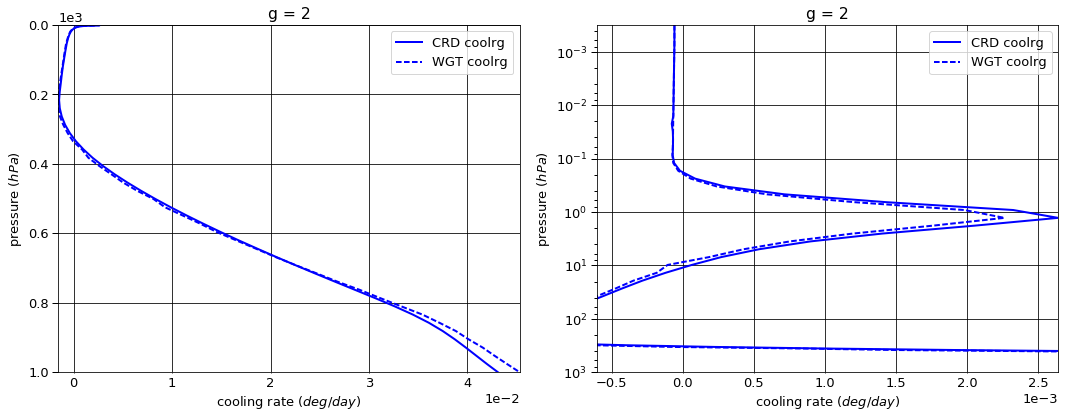

# Figure: cooling rate g-group 3

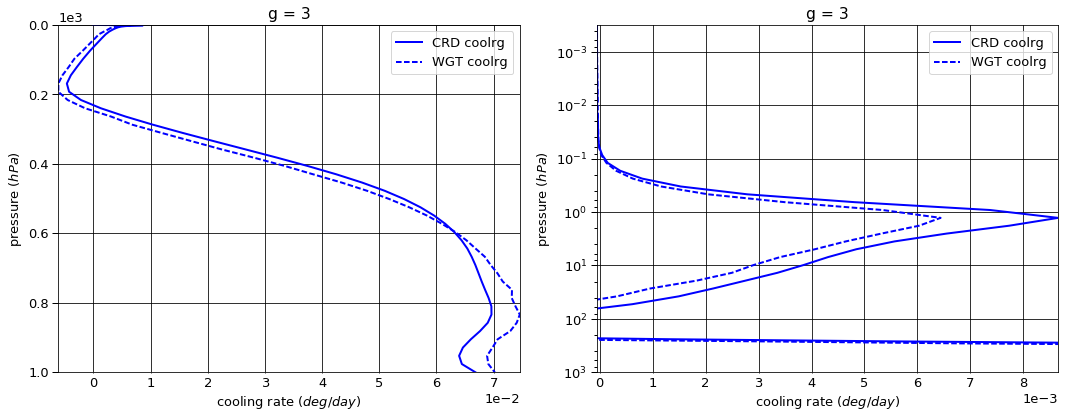

# Figure: cooling rate g-group 4

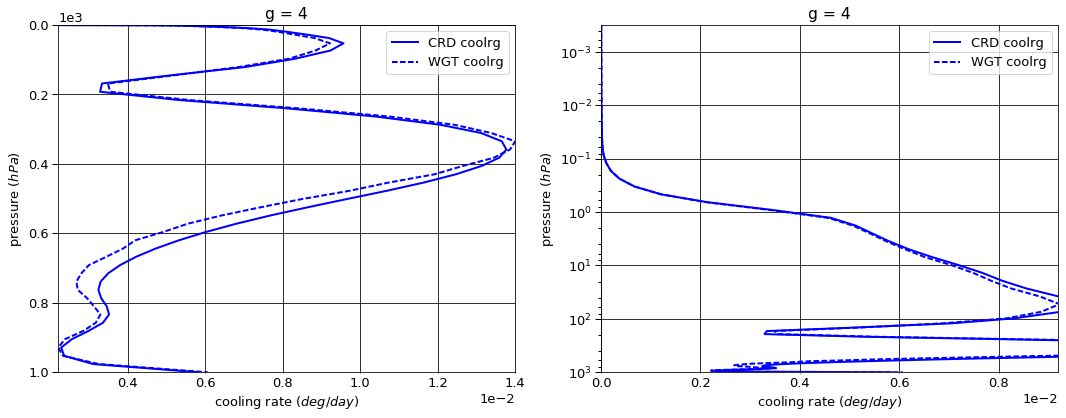

# Figure: cooling rate g-group 5

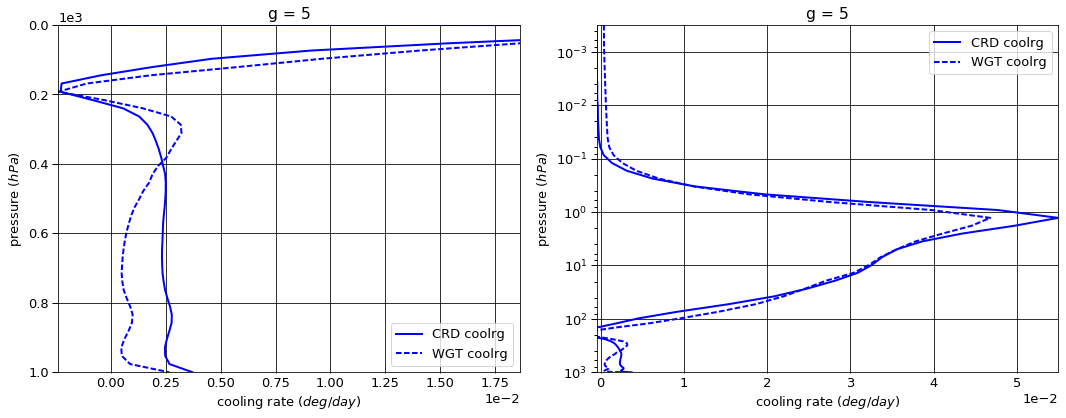

# Figure: cooling rate g-group 6

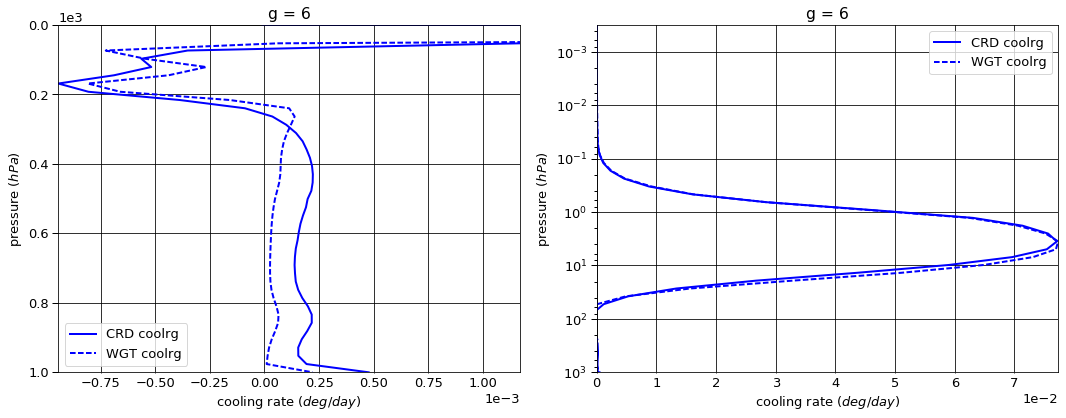

# Figure: cooling rate g-group 7

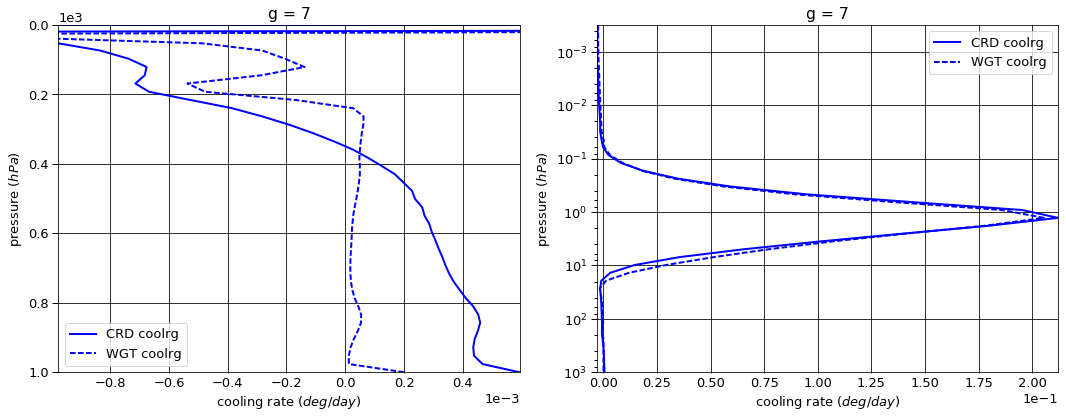

# Figure: cooling rate g-group 8

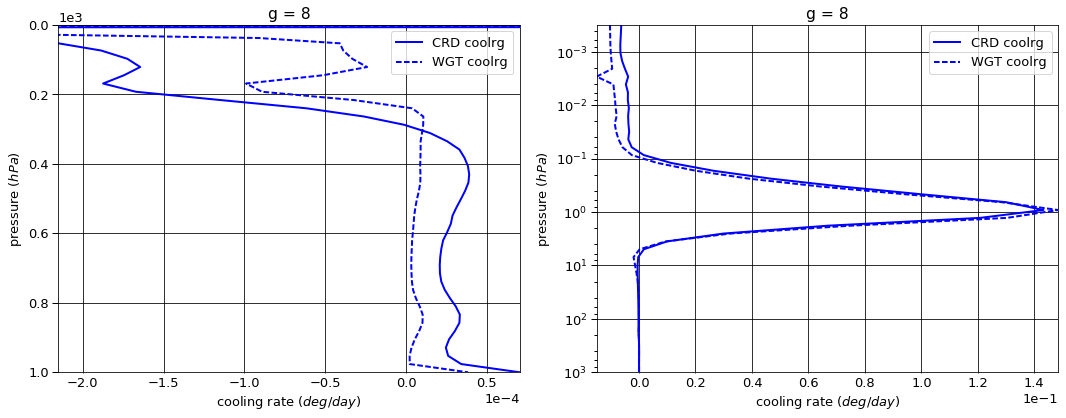

# Figure: cooling rate g-group 9

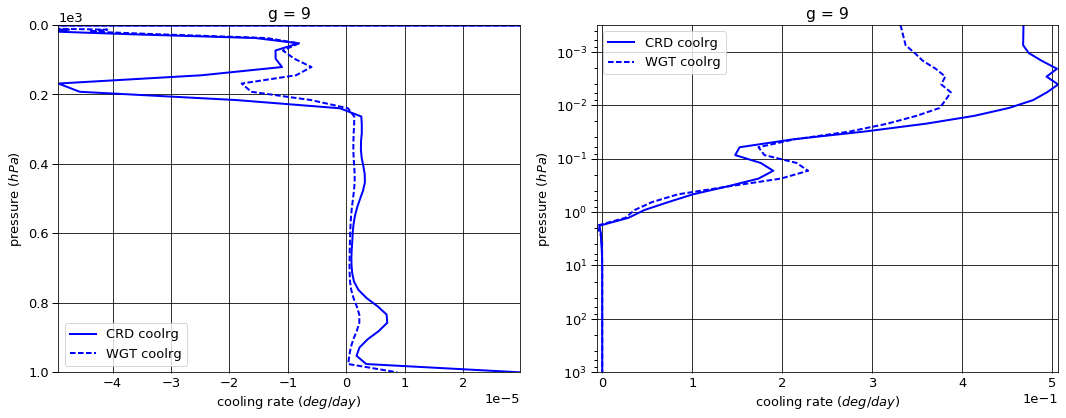

# Figure: cooling rate g-group total

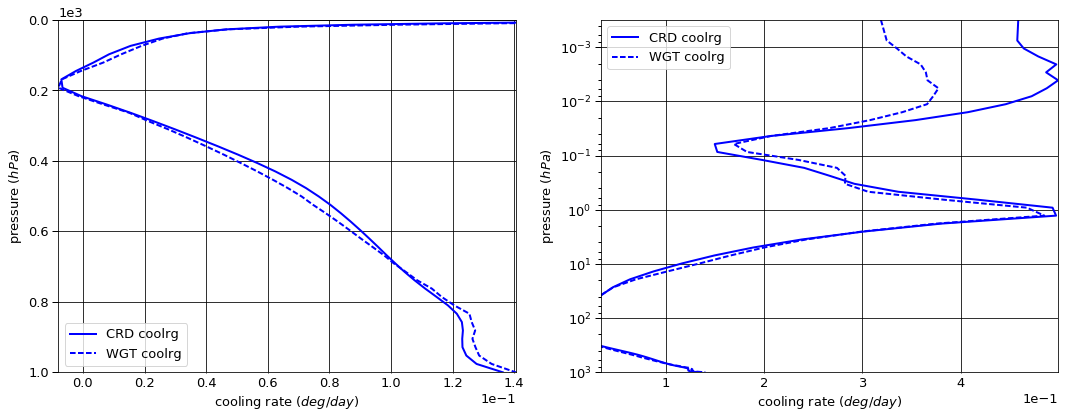

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1     -11.645191  0.000000 -11.645191
  1013.0   76    -11.775941  0.613046 -11.162895
2 0.0      1      -6.315205  0.000000  -6.315205
  1013.0   76     -6.944650  2.322749  -4.621902
3 0.0      1      -6.318527  0.000000  -6.318527
  1013.0   76     -9.673479  8.169070  -1.504409
4 0.0      1      -0.864359  0.000000  -0.864359
  1013.0   76     -2.275827  2.244898  -0.030928
5 0.0      1      -0.518990  0.000000  -0.518990
  1013.0   76     -1.284243  1.188531  -0.095712
6 0.0      1      -0.163208  0.000000  -0.163208
  1013.0   76     -0.399625  0.395972  -0.003653
7 0.0      1      -0.113902  0.000000  -0.113902
  1013.0   76     -0.206199  0.191331  -0.014868
8 0.0      1      -0.025032  0.000000  -0.025032
  1013.0   76     -0.039637  0.039172  -0.000465
9 0.0      1      -0.014466  0.000000  -0.014466
  1013.0   76     -0.037941  0.037847  -0.000094


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1     -11.645894  0.000000 -11.645894
  1013.0   76    -11.775941  0.610301 -11.165640
2 0.0      1      -6.315386  0.000000  -6.315386
  1013.0   76     -6.944650  2.346654  -4.597996
3 0.0      1      -6.349131  0.000000  -6.349131
  1013.0   76     -9.673479  8.153514  -1.519966
4 0.0      1      -0.823472  0.000000  -0.823472
  1013.0   76     -2.275827  2.244894  -0.030933
5 0.0      1      -0.394301  0.000000  -0.394301
  1013.0   76     -1.284243  1.274003  -0.010241
6 0.0      1      -0.163176  0.000000  -0.163176
  1013.0   76     -0.399625  0.399017  -0.000609
7 0.0      1      -0.107831  0.000000  -0.107831
  1013.0   76     -0.206199  0.205628  -0.000572
8 0.0      1      -0.025719  0.000000  -0.025719
  1013.0   76     -0.039637  0.039528  -0.000109
9 0.0      1      -0.013716  0.000000  -0.013716
  1013.0   76     -0.037941  0.037917  -0.000024


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000703  0.000000 -0.000703
  1013.0   76     0.000000 -0.002744 -0.002745
2 0.0      1     -0.000181  0.000000 -0.000181
  1013.0   76     0.000000  0.023905  0.023905
3 0.0      1     -0.030604  0.000000 -0.030604
  1013.0   76     0.000000 -0.015557 -0.015557
4 0.0      1      0.040888  0.000000  0.040888
  1013.0   76     0.000000 -0.000005 -0.000005
5 0.0      1      0.124689  0.000000  0.124689
  1013.0   76     0.000000  0.085471  0.085471
6 0.0      1      0.000031  0.000000  0.000031
  1013.0   76     0.000000  0.003044  0.003044
7 0.0      1      0.006071  0.000000  0.006071
  1013.0   76     0.000000  0.014297  0.014297
8 0.0      1     -0.000687  0.000000 -0.000687
  1013.0   76     0.000000  0.000356  0.000356
9 0.0      1      0.000750  0.000000  0.000750
  1013.0   76     0.000000  0.000069  0.000069

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.000042
  1001.112500 75     0.015603
2 0.000312    1     -0.000058
  1001.112500 75     0.043119
3 0.000312    1     -0.000052
  1001.112500 75     0.066816
4 0.000312    1      0.000005
  1001.112500 75     0.005846
5 0.000312    1     -0.000471
  1001.112500 75     0.003720
6 0.000312    1     -0.000008
  1001.112500 75     0.000477
7 0.000312    1     -0.002663
  1001.112500 75     0.000594
8 0.000312    1     -0.006274
  1001.112500 75     0.000070
9 0.000312    1      0.468105
  1001.112500 75     0.000030


WGT


coolrg
g pressure    layer          
1 0.000312    1     -0.000043
  1001.112500 75     0.015743
2 0.000312    1     -0.000058
  1001.112500 75     0.045332
3 0.000312    1     -0.000049
  1001.112500 75     0.070200
4 0.000312    1      0.000007
  1001.112500 75     0.006076
5 0.000312    1      0.000401
  1001.112500 75     0.002663
6 0.000312    1      0.000015
  1001.112500 75     0.000220
7 0.000312    1     -0.002493
  1001.112500 75     0.000202
8 0.000312    1     -0.010285
  1001.112500 75     0.000038
9 0.000312    1      0.331422
  1001.112500 75     0.000009


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.517790e-07
  1001.112500 75     1.400850e-04
2 0.000312    1      8.452500e-08
  1001.112500 75     2.213216e-03
3 0.000312    1      3.162623e-06
  1001.112500 75     3.383364e-03
4 0.000312    1      1.962019e-06
  1001.112500 75     2.297737e-04
5 0.000312    1      8.714439e-04
  1001.112500 75    -1.057141e-03
6 0.000312    1      2.347129e-05
  1001.112500 75    -2.572602e-04
7 0.000312    1      1.706843e-04
  1001.112500 75    -3.925523e-04
8 0.000312    1     -4.011475e-03
  1001.112500 75    -3.198905e-05
9 0.000312    1     -1.366823e-01
  1001.112500 75    -2.098229e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.978879,0.000000,-25.978879
1013.0,76,-32.637543,15.202617,-17.434926



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.838626,0.000000,-25.838626
1013.0,76,-32.637543,15.311454,-17.326089



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.140253,0.000000,0.140253
1013.0,76,0.000000,0.108838,0.108837


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.458541
1001.112500,75,0.136275



WGT


,,coolrg
pressure,layer,
0.000312,1,0.318917
1001.112500,75,0.140481



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.139624
1001.112500,75,0.004207


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.369312,0.354380
2,0.213688,0.211927
3,0.290187,0.301164
4,0.067937,0.071126
5,0.038500,0.040013
6,0.011875,0.012540
7,0.006188,0.006422
8,0.001187,0.001235
9,0.001125,0.001193


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.959058e-25
2,6.378566e-24
3,6.102842e-23
4,5.839038e-22
5,1.581825e-22
6,1.678020e-21
7,1.826139e-21
8,1.947095e-20
9,2.076063e-19


In [23]:
def spreadsheet():
    ng = 9
    ng_refs = [3, 2, 4]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref[::-1], 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.959058e-25,NaN,0.369312,0.354380,0.369312,0.354380,500.0
2,6.378566e-24,21.556067,0.213688,0.211927,0.583000,0.566307,500.0
3,6.102842e-23,9.567734,0.290187,0.301164,0.873188,0.867471,500.0
4,5.839038e-22,9.567735,0.067937,0.071126,0.941125,0.938597,500.0
5,1.581825e-22,0.270905,0.038500,0.040013,0.979625,0.978610,10.0
6,1.678020e-21,10.608128,0.011875,0.012540,0.991500,0.991150,10.0
7,1.826139e-21,1.088270,0.006188,0.006422,0.997687,0.997572,1.0
8,1.947095e-20,10.662360,0.001187,0.001235,0.998875,0.998807,1.0
9,2.076063e-19,10.662360,0.001125,0.001193,1.000000,1.000000,1.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  4.867747e-26  6.347370e-27   7.668920
      2     0.000312  1.573280e-25  6.737860e-26   2.334984
      3     0.000312  3.285961e-25  2.663965e-25   1.233485
      4     0.000312  1.709371e-25  1.693078e-25   1.009624
      5     0.000312  2.067295e-23  1.146875e-23   1.802545
      6     0.000312  1.194255e-23  1.131529e-23   1.055435
      7     0.000312  9.908171e-22  6.624178e-22   1.495758
      8     0.000312  1.557905e-20  8.963400e-21   1.738074
      9     0.000312  5.535756e-19  3.105266e-19   1.782699
2     1     0.000750  4.938897e-26  6.390642e-27   7.728327
      2     0.000750  1.595045e-25  6.794465e-26   2.347565
      3     0.000750  3.324951e-25  2.691277e-25   1.235455
      4     0.000750  1.740707e-25  1.724068e-25   1.009651
      5     0.000750  2.089261e-23  1.155906e-23   1.807465
      6     0.000750  1.220466e-23  1.156597e-23   1.055221
      7     0.000750  1.000125e-21  6.674017e-22   1.498536
      8     0.000750  1.569554e-20  9.031540e-21   1.737859
      9     0.000750  5.559891e-19  3.116656e-19   1.783928
3     1     0.001052  5.092989e-26  6.480880e-27   7.858484
      2     0.001052  1.641801e-25  6.911446e-26   2.375482
      3     0.001052  3.406799e-25  2.747574e-25   1.239930
      4     0.001052  1.792640e-25  1.775241e-25   1.009801
      5     0.001052  2.135231e-23  1.173718e-23   1.819203
      6     0.001052  1.258743e-23  1.192348e-23   1.055684
      7     0.001052  1.019516e-21  6.771830e-22   1.505525
      8     0.001052  1.594171e-20  9.172776e-21   1.737937
      9     0.001052  5.611659e-19  3.140854e-19   1.786667
4     1     0.001476  5.261167e-26  6.578012e-27   7.998110
      2     0.001476  1.692785e-25  7.037034e-26   2.405537
      3     0.001476  3.495905e-25  2.808566e-25   1.244730
      4     0.001476  1.851611e-25  1.833371e-25   1.009949
      5     0.001476  2.185212e-23  1.192984e-23   1.831720
      6     0.001476  1.303244e-23  1.234066e-23   1.056056
      7     0.001476  1.040516e-21  6.877693e-22   1.512884
      8     0.001476  1.620676e-20  9.324989e-21   1.737992
      9     0.001476  5.666714e-19  3.166655e-19   1.789495
5     1     0.002070  5.434879e-26  6.677192e-27   8.139468
      2     0.002070  1.745431e-25  7.165009e-26   2.436048
      3     0.002070  3.587936e-25  2.871326e-25   1.249575
      4     0.002070  1.916487e-25  1.897368e-25   1.010077
      5     0.002070  2.236771e-23  1.212850e-23   1.844227
      6     0.002070  1.353872e-23  1.281797e-23   1.056229
      7     0.002070  1.062093e-21  6.987053e-22   1.520088
      8     0.002070  1.647707e-20  9.480641e-21   1.737971
      9     0.002070  5.722039e-19  3.192683e-19   1.792235
6     1     0.002904  5.614163e-26  6.778687e-27   8.282081
      2     0.002904  1.799789e-25  7.295813e-26   2.466879
      3     0.002904  3.683159e-25  2.936111e-25   1.254434
      4     0.002904  1.989186e-25  1.969146e-25   1.010177
      5     0.002904  2.290060e-23  1.233483e-23   1.856580
      6     0.002904  1.412829e-23  1.337743e-23   1.056129
      7     0.002904  1.084310e-21  7.100974e-22   1.526989
      8     0.002904  1.675290e-20  9.640180e-21   1.737821
      9     0.002904  5.777545e-19  3.218925e-19   1.794868
7     1     0.004074  5.799231e-26  6.883002e-27   8.425438
      2     0.004074  1.855980e-25  7.430247e-26   2.497871
      3     0.004074  3.782049e-25  3.003367e-25   1.259270
      4     0.004074  2.072476e-25  2.051473e-25   1.010238
      5     0.004074  2.345349e-23  1.255145e-23   1.868588
      6     0.004074  1.483272e-23  1.405060e-23   1.055665
      7     0.004074  1.107278e-21  7.221102e-22   1.533393
      8     0.004074  1.703492e-20  9.804437e-21   1.737471
      9     0.004074  5.833173e-19  3.245399e-19   1.797367
8     1     0.005714  5.990320e-26  6.990858e-27   8.568791
      2     0.005714  1.914160e-25  7.569462e-26   2

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')